In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import sys
import pathlib
import pickle
import warnings

sys.path.append('..')

In [4]:
import pandas as pd
from loguru import logger
import seaborn as sns

In [5]:
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp
from pals.noise import construct_intensity_df, add_random_peaks, plot_intensity_matrix, convert_to_data_source
from pals.feature_extraction import DataSource
from pals.PALS import PALS
from pals.ORA import ORA
from pals.common import *

2020-01-01 00:56:52.501 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2020-01-01 00:56:52.501 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2020-01-01 00:56:53.571 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


## Synthetic data test

Try generating some synthetic data without noise

In [6]:
control_fnames = ['Control_1.mzXML', 'Control_2.mzXML', 'Control_3.mzXML', 'Control_4.mzXML']
case_fnames = ['Case_1.mzXML', 'Case_2.mzXML', 'Case_3.mzXML', 'Case_4.mzXML']
sample_fnames = control_fnames + case_fnames
pathway_names ={'two':2, 'four':4, 'six':6, 'ten':10, 'twenty':20, 'forty':40, 'eighty':80}
NUM_ITERATIONS = 500
BG_PW = 100

base_dir = os.path.join('test_data', 'synthetic')
create_if_not_exist(base_dir)

(2859, 8)
{'two': 2, 'four': 4, 'six': 6, 'ten': 10, 'twenty': 20, 'forty': 40, 'eighty': 80, 'background0': 8, 'background1': 27, 'background2': 22, 'background3': 48, 'background4': 15, 'background5': 22, 'background6': 16, 'background7': 30, 'background8': 14, 'background9': 10, 'background10': 28, 'background11': 25, 'background12': 42, 'background13': 47, 'background14': 28, 'background15': 35, 'background16': 29, 'background17': 18, 'background18': 16, 'background19': 30, 'background20': 44, 'background21': 15, 'background22': 35, 'background23': 32, 'background24': 21, 'background25': 12, 'background26': 21, 'background27': 19, 'background28': 34, 'background29': 31, 'background30': 31, 'background31': 40, 'background32': 45, 'background33': 18, 'background34': 15, 'background35': 21, 'background36': 29, 'background37': 16, 'background38': 35, 'background39': 19, 'background40': 16, 'background41': 33, 'background42': 17, 'background43': 44, 'background44': 47, 'background45': 2

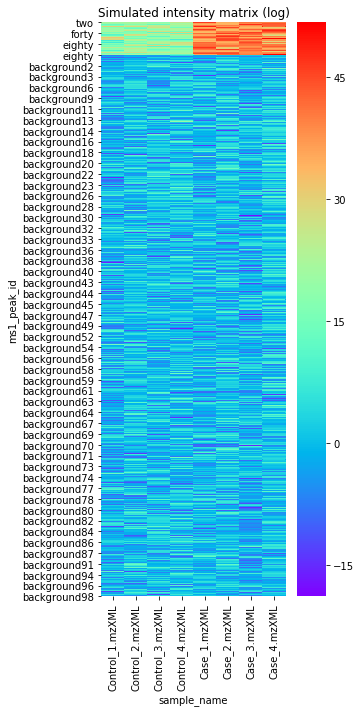

In [7]:
int_df, updated_pathway_names = construct_intensity_df(sample_fnames, pathway_names, random=False, background_pathways=BG_PW)
print(int_df.shape)
print(updated_pathway_names)

out_file = os.path.join(base_dir, 'simulated_intensity.eps')
plot_intensity_matrix(int_df, out_file=out_file)

Convert simulated data above to a PALS DataSource object and run pathway analysis

In [8]:
min_replace = 5000
plage_weight = 5
hg_weight = 1
prob_missing_peaks = 0.2

In [9]:
ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks, min_replace)
pals = PALS(ds, plage_weight=plage_weight, hg_weight=hg_weight)

2020-01-01 00:57:06.134 | DEBUG    | pals.noise:convert_to_data_source:111 - Dataset annotations = 2859
2020-01-01 00:57:06.135 | DEBUG    | pals.noise:convert_to_data_source:115 - Sampled annotations = 2287 with prob_missing_peaks=0.20
2020-01-01 00:57:06.135 | DEBUG    | pals.feature_extraction:__init__:43 - Using user-provided database
2020-01-01 00:57:06.136 | DEBUG    | pals.feature_extraction:__init__:51 - Mapping pathway to unique ids
2020-01-01 00:57:06.138 | DEBUG    | pals.feature_extraction:__init__:65 - Creating dataset to pathway mapping
2020-01-01 00:57:06.301 | DEBUG    | pals.feature_extraction:__init__:93 - Computing unique id counts


In [10]:
pals_df = pals.get_pathway_df()
pals_df.sort_values('pw_name')

2020-01-01 00:57:06.372 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:407 - Setting the zero intensity values in the dataframe
2020-01-01 00:57:06.387 | DEBUG    | pals.pathway_analysis:_standardize_intensity_df:388 - Scaling the data across the sample: zero mean and unit variance
2020-01-01 00:57:06.389 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:215 - Mean values of the rows in the DF is [-0. -0.  0. ... -0.  0.  0.]
2020-01-01 00:57:06.390 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:216 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2020-01-01 00:57:06.596 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:227 - Calculating plage p-values with resampling
2020-01-01 00:57:06.597 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:231 - Comparison case/control
2020-01-01 00:57:06.597 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:239 - Resampling 0/1000
2020-01-01 00:57:06.699 | DEBUG    | pals.path

,pw_name,case/control p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,case/control comb_p
background0,background0,1.000000,8,8,100.00,0.167244,6.4,80.0,1.000000
background1,background1,1.000000,27,18,66.67,0.970154,21.6,80.0,1.000000
background10,background10,1.000000,28,22,78.57,0.678618,22.4,80.0,1.000000
background11,background11,1.000000,25,21,84.00,0.419641,20.0,80.0,1.000000
background12,background12,1.000000,42,34,80.95,0.530236,33.6,80.0,1.000000
...,...,...,...,...,...,...,...,...,...
four,four,0.012963,4,4,100.00,0.409242,3.2,80.0,0.012905
six,six,0.036672,6,5,83.33,0.655188,4.8,80.0,0.046714
ten,ten,0.029410,10,8,80.00,0.677694,8.0,80.0,0.039003
twenty,twenty,0.005676,20,16,80.00,0.629496,16.0,80.0,0.007810


In [11]:
ora_df = pals.get_ora_df(correct_multiple_tests=True)
ora_df.sort_values('pw_name')

2020-01-01 00:57:08.080 | DEBUG    | pals.pathway_analysis:get_ora_df:50 - Calculating ORA
2020-01-01 00:57:08.081 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:407 - Setting the zero intensity values in the dataframe
2020-01-01 00:57:08.688 | DEBUG    | pals.pathway_analysis:get_ora_df:111 - Correcting for multiple t-tests
2020-01-01 00:57:08.693 | DEBUG    | pals.pathway_analysis:_calculate_coverage_df:493 - Calculating dataset formula coverage


,pw_name,case/control p-value,case/control comb_p,unq_pw_F,tot_ds_F,F_coverage
mapids,,,,,,
background0,background0,5.224673e-01,1.000000e+00,8,8,100.00
background1,background1,1.000000e+00,1.000000e+00,27,18,66.67
background10,background10,9.254643e-01,1.000000e+00,28,22,78.57
background11,background11,9.014310e-01,1.000000e+00,25,21,84.00
background12,background12,8.967653e-01,1.000000e+00,42,34,80.95
...,...,...,...,...,...,...
four,four,5.905665e-05,1.053177e-03,4,4,100.00
six,six,2.855992e-05,6.111822e-04,6,5,83.33
ten,ten,1.263337e-07,3.379426e-06,10,8,80.00


Now take the synthetic data matrix above, add some noisy peaks (100%) and run pathway analysis methods again.

(3021, 8)


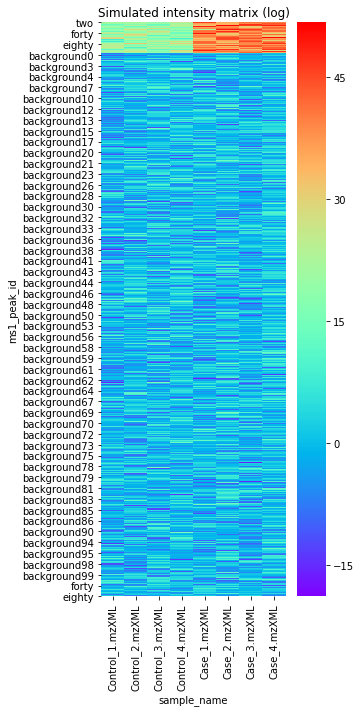

In [12]:
percent = 100
noise_mean = 0
noise_std = 5
int_df = add_random_peaks(sample_fnames, pathway_names, int_df, percent, noise_mean, noise_std)
print(int_df.shape)
plot_intensity_matrix(int_df)

In [13]:
ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks, min_replace)
pals = PALS(ds, plage_weight=plage_weight, hg_weight=hg_weight)

2020-01-01 00:57:09.890 | DEBUG    | pals.noise:convert_to_data_source:111 - Dataset annotations = 3021
2020-01-01 00:57:09.891 | DEBUG    | pals.noise:convert_to_data_source:115 - Sampled annotations = 2417 with prob_missing_peaks=0.20
2020-01-01 00:57:09.892 | DEBUG    | pals.feature_extraction:__init__:43 - Using user-provided database
2020-01-01 00:57:09.892 | DEBUG    | pals.feature_extraction:__init__:51 - Mapping pathway to unique ids
2020-01-01 00:57:09.894 | DEBUG    | pals.feature_extraction:__init__:65 - Creating dataset to pathway mapping
2020-01-01 00:57:10.066 | DEBUG    | pals.feature_extraction:__init__:93 - Computing unique id counts


In [14]:
pals_df = pals.get_pathway_df()
pals_df.sort_values('pw_name')

2020-01-01 00:57:10.141 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:407 - Setting the zero intensity values in the dataframe
2020-01-01 00:57:10.156 | DEBUG    | pals.pathway_analysis:_standardize_intensity_df:388 - Scaling the data across the sample: zero mean and unit variance
2020-01-01 00:57:10.158 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:215 - Mean values of the rows in the DF is [-0. -0.  0. ... -0.  0.  0.]
2020-01-01 00:57:10.159 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:216 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2020-01-01 00:57:10.378 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:227 - Calculating plage p-values with resampling
2020-01-01 00:57:10.379 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:231 - Comparison case/control
2020-01-01 00:57:10.379 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:239 - Resampling 0/1000
2020-01-01 00:57:10.481 | DEBUG    | pals.path

,pw_name,case/control p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,case/control comb_p
background0,background0,1.000000,8,6,75.00,0.797283,6.4,80.0,1.000000
background1,background1,1.000000,27,25,92.59,0.071010,21.6,80.0,1.000000
background10,background10,1.000000,28,27,96.43,0.015173,22.4,80.0,1.000000
background11,background11,0.999999,25,17,68.00,0.954016,20.0,80.0,1.000000
background12,background12,1.000000,42,34,80.95,0.531141,33.6,80.0,1.000000
...,...,...,...,...,...,...,...,...,...
four,four,0.068691,8,8,100.00,0.167494,6.4,80.0,0.049898
six,six,0.007334,12,10,83.33,0.558463,9.6,80.0,0.009034
ten,ten,0.046822,20,16,80.00,0.630084,16.0,80.0,0.057191
twenty,twenty,0.006638,40,33,82.50,0.436729,32.0,80.0,0.006957


In [15]:
ora_df = pals.get_ora_df(correct_multiple_tests=False)
ora_df.sort_values('pw_name')

2020-01-01 00:57:11.740 | DEBUG    | pals.pathway_analysis:get_ora_df:50 - Calculating ORA
2020-01-01 00:57:11.742 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:407 - Setting the zero intensity values in the dataframe
2020-01-01 00:57:12.346 | DEBUG    | pals.pathway_analysis:get_ora_df:113 - Not correcting for multiple t-tests
2020-01-01 00:57:12.349 | DEBUG    | pals.pathway_analysis:_calculate_coverage_df:493 - Calculating dataset formula coverage


,pw_name,case/control p-value,case/control comb_p,unq_pw_F,tot_ds_F,F_coverage
mapids,,,,,,
background0,background0,5.036885e-01,5.036885e-01,8,6,75.00
background1,background1,1.000000e+00,1.000000e+00,27,25,92.59
background10,background10,9.146052e-01,9.146052e-01,28,27,96.43
background11,background11,8.887194e-01,8.887194e-01,25,17,68.00
background12,background12,8.789079e-01,8.789079e-01,42,34,80.95
...,...,...,...,...,...,...
four,four,2.566437e-03,2.566437e-03,8,8,100.00
six,six,1.952721e-04,1.952721e-04,12,10,83.33
ten,ten,7.963958e-04,7.963958e-04,20,16,80.00


### Experiments

The following are all the methods we need to run our experiments

In [16]:
def run_experiment(reqd_scenarios, sample_fnames, pathway_names, num_iterations):
    pals_dfs = []
    ora_dfs = []
    for i in range(len(reqd_scenarios)):
        scenario = reqd_scenarios[i]
        logger.info(scenario)
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', r'divide by zero')
            results = calc_av_p_scores(sample_fnames, pathway_names, num_iterations, 
                                  percent=scenario['percent'], random=scenario['random'], noise_std=scenario['noise_std'],
                                  prob_missing_peaks=scenario['prob_missing_peaks'], 
                                  background_pathways=scenario['background_pathways'])
        df = construct_single_box_df(results, scenario['percent'], scenario['prob_missing_peaks'], scenario['noise_std'], 'pals')        
        pals_dfs.append(df)
        df = construct_single_box_df(results, scenario['percent'], scenario['prob_missing_peaks'], scenario['noise_std'], 'ora')        
        ora_dfs.append(df)   

    pals_df = pd.concat(pals_dfs, axis=0)
    ora_df = pd.concat(ora_dfs, axis=0)
    return pals_df, ora_df

In [17]:
def calc_av_p_scores(sample_fnames, pathway_names, num_iterations, percent=0, random=False, 
                     noise_mean=0, noise_std=5, prob_missing_peaks=0.2, background_pathways=100, min_replace=MIN_REPLACE):
    results = {
        'pals': [],
        'ora': []
    }
    
    set_log_level_info()
    for it in range(num_iterations):
        if it % 100 == 0:
            logger.info('Iteration %d' % it)

        # constructs the peak intensity dataframe, adding random peaks if necessary
        int_df, updated_pathway_names = construct_intensity_df(sample_fnames, pathway_names, random=random,
                                                       background_pathways=background_pathways)        
        int_df = add_random_peaks(sample_fnames, pathway_names, int_df, percent, noise_mean, noise_std)
            
        ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks, min_replace)        
        pals = PALS(ds, plage_weight=3, hg_weight=1)
        pathway_df = pals.get_pathway_df()
        ora_df = pals.get_ora_df(correct_multiple_tests=True)
        
        results['pals'].append(pathway_df)
        results['ora'].append(ora_df)

    set_log_level_debug()
    return results

In [18]:
def construct_single_box_df(results, random_peaks, prob_missing, noise_std, method):
    df = pd.concat(results[method], axis=0)
    columns = ['pathway', 'percent', 'prob_missing', 'noise_std', 'p_value', 'comb_p_value', 'method']
    box_plot_df = pd.DataFrame(columns=columns)
    box_plot_df['pathway'] = list(df.index)
    box_plot_df['percent'] = float(random_peaks)
    box_plot_df['prob_missing'] = float(prob_missing)    
    box_plot_df['noise_std'] = float(noise_std)        
    box_plot_df['p_value'] = df['case/control p-value'].values
    box_plot_df['comb_p_value'] = df['case/control comb_p'].values
    box_plot_df['method'] = method
    box_plot_df = box_plot_df[~box_plot_df.pathway.str.contains("background")]
    return box_plot_df

### Experiment 1: adding noise

In this experiment, we add some % of noise to the data, and compares how the different methods perform.

In [ ]:
out_file = os.path.join(base_dir, 'experiment_1.p')

In [ ]:
prob_missing_peaks = 0.20
random = False # whether to sample intensity data randomly or using pre-set values
reqd_scenarios = [
    { 'background_pathways': BG_PW, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 0, 'prob_missing_peaks': prob_missing_peaks },
    { 'background_pathways': BG_PW, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 25, 'prob_missing_peaks': prob_missing_peaks },
    { 'background_pathways': BG_PW, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 50, 'prob_missing_peaks': prob_missing_peaks },
    { 'background_pathways': BG_PW, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 100, 'prob_missing_peaks': prob_missing_peaks },        
    { 'background_pathways': BG_PW, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 250, 'prob_missing_peaks': prob_missing_peaks },
    { 'background_pathways': BG_PW, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 500, 'prob_missing_peaks': prob_missing_peaks },
    { 'background_pathways': BG_PW, 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 1000, 'prob_missing_peaks': prob_missing_peaks },
]
pals_df, ora_df = run_experiment(reqd_scenarios, sample_fnames, pathway_names, NUM_ITERATIONS)
combined_df = pd.concat([pals_df, ora_df])

In [ ]:
results = {
    'pals_df': pals_df,
    'ora_df': ora_df,
    'combined_df': combined_df
}
save_obj(results, out_file)

#### Load experiment results

In [36]:
out_file = os.path.join(base_dir, 'experiment_1.p')

In [37]:
results = load_obj(out_file)
pals_df = results['pals_df']
ora_df = results['ora_df']
combined_df = results['combined_df']

In [38]:
pals_df.groupby('percent').describe()

prob_missing                                             noise_std  \
               count mean           std  min  25%  50%  75%  max     count   
percent                                                                      
0.0           3482.0  0.2  2.775956e-17  0.2  0.2  0.2  0.2  0.2    3482.0   
25.0          3498.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3498.0   
50.0          3494.0  0.2  2.775955e-17  0.2  0.2  0.2  0.2  0.2    3494.0   
100.0         3498.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3498.0   
250.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
500.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
1000.0        3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   

              ...   p_value           comb_p_value                      \
        mean  ...       75%       max        count      mean       std   
percent       ...                                                        
0.0      5.0  ...  0.018761  0.976162       3482.0  0.043181  0.092661   
25.0     5.0  ...  0.030090  1.000000       3498.0  0.077900  0.186281   
50.0     5.0  ...  0.036478  1.000000       3494.0  0.083294  0.186808   
100.0    5.0  ...  0.054063  1.000000       3498.0  0.106559  0.221115   
250.0    5.0  ...  0.120657  1.000000       3500.0  0.171815  0.288589   
500.0    5.0  ...  0.307157  1.000000       3500.0  0.249121  0.347699   
1000.0   5.0  ...  0.705996  1.000000       3500.0  0.347520  0.392782   

                                                               
                  min       25%       50%       75%       max  
percent                                                        
0.0      8.945866e-07  0.002013  0.010151  0.039649  0.992497  
25.0     2.334568e-06  0.002405  0.013259  0.056057  1.000000  
50.0     6.999981e-07  0.003109  0.015257  0.066701  1.000000  
100.0    3.597871e-06  0.003423  0.019068  0.087394  1.000000  
250.0    1.592171e-05  0.005790  0.031019  0.167061  1.000000  
500.0    1.319435e-07  0.008481  0.059090  0.368503  1.000000  
1000.0   1.034268e-05  0.017376  0.133211  0.744967  1.000000  

[7 rows x 32 columns]

In [39]:
ora_df.groupby('percent').describe()

prob_missing                                             noise_std  \
               count mean           std  min  25%  50%  75%  max     count   
percent                                                                      
0.0           3482.0  0.2  2.775956e-17  0.2  0.2  0.2  0.2  0.2    3482.0   
25.0          3498.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3498.0   
50.0          3494.0  0.2  2.775955e-17  0.2  0.2  0.2  0.2  0.2    3494.0   
100.0         3498.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3498.0   
250.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
500.0         3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   
1000.0        3500.0  0.2  0.000000e+00  0.2  0.2  0.2  0.2  0.2    3500.0   

              ...   p_value      comb_p_value                      \
        mean  ...       75%  max        count      mean       std   
percent       ...                                                   
0.0      5.0  ...  0.000669  1.0       3482.0  0.080366  0.235728   
25.0     5.0  ...  0.002227  1.0       3498.0  0.111168  0.263063   
50.0     5.0  ...  0.004354  1.0       3494.0  0.123123  0.273185   
100.0    5.0  ...  0.009739  1.0       3498.0  0.163513  0.302219   
250.0    5.0  ...  0.026107  1.0       3500.0  0.291409  0.412080   
500.0    5.0  ...  0.088234  1.0       3500.0  0.425802  0.443567   
1000.0   5.0  ...  0.191672  1.0       3500.0  0.598218  0.444690   

                                                              
                  min           25%       50%       75%  max  
percent                                                       
0.0      4.187502e-72  3.319928e-24  0.000002  0.014211  1.0  
25.0     6.149111e-61  3.890728e-20  0.000023  0.044855  1.0  
50.0     2.455233e-56  4.403551e-17  0.000118  0.087931  1.0  
100.0    2.255642e-48  7.277074e-14  0.000600  0.188527  1.0  
250.0    2.200256e-31  2.642090e-08  0.017278  0.479248  1.0  
500.0    1.098149e-21  1.046149e-04  0.201711  1.000000  1.0  
1000.0   2.828646e-11  4.317979e-02  0.943463  1.000000  1.0  

[7 rows x 32 columns]

Define seaborn styles. This will affect all plots from hereon.

In [40]:
sns.set(style="ticks")
style.use('seaborn-poster') #sets the size of the charts
sns.set_context('poster')  #Everything is larger

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


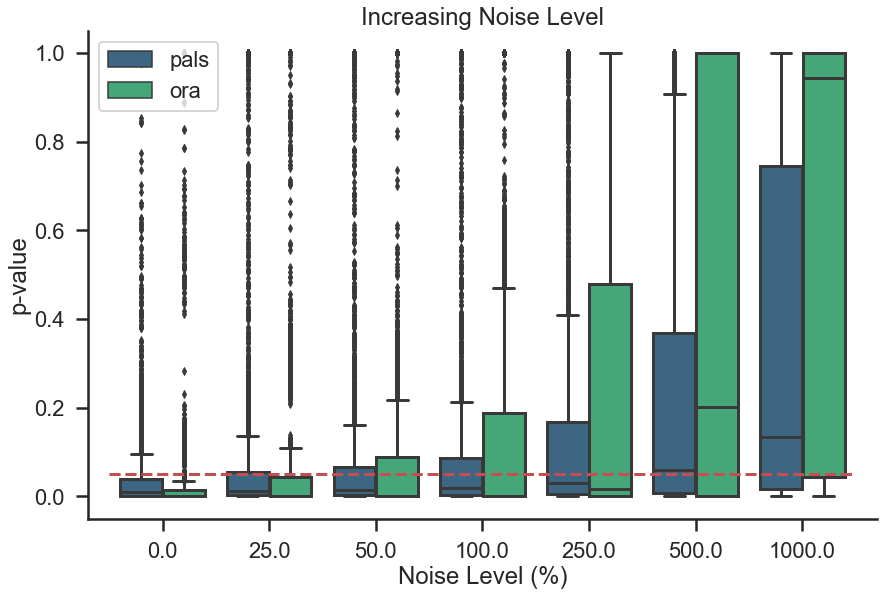

In [41]:
ax = sns.boxplot(x="percent", y="comb_p_value", hue='method', data=combined_df, palette=("viridis"))
ax.set(xlabel='Noise Level (%)', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Increasing Noise Level')
plt.legend(loc='upper left')
plt.tight_layout()
sns.despine()

out_file = os.path.join(base_dir, 'adding_noise.eps')
plt.savefig(out_file, dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


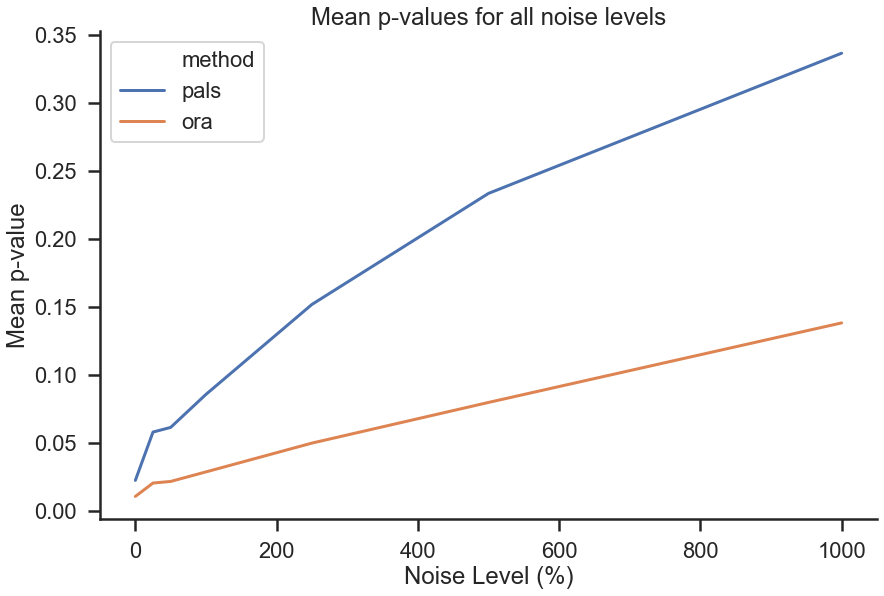

In [42]:
pals_pvalue_mean = pd.DataFrame(pals_df.groupby('percent').describe()['p_value']['mean'])
ora_pvalue_mean = pd.DataFrame(ora_df.groupby('percent').describe()['p_value']['mean'])

pals_pvalue_mean['method'] = 'pals'
ora_pvalue_mean['method'] = 'ora'
combined_df = pd.concat([pals_pvalue_mean, ora_pvalue_mean])
ax = sns.lineplot(data=combined_df.reset_index(), x='percent', y='mean', hue='method')
ax.set(xlabel='Noise Level (%)', ylabel='Mean p-value')
plt.title('Mean p-values for all noise levels')

plt.tight_layout()
sns.despine()

out_file = os.path.join(base_dir, 'mean_pvalues.eps')
plt.savefig(out_file, dpi=300)

#### Plot for individual pathways

Make lineplot

In [123]:
sns.set(style="whitegrid")
style.use('seaborn-poster') #sets the size of the charts
sns.set_context('poster')  #Everything is larger

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


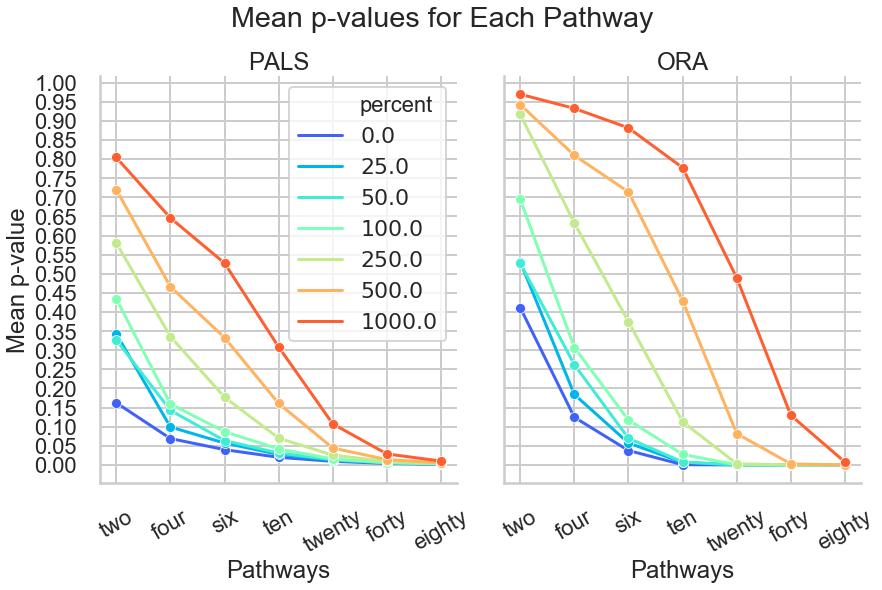

In [196]:
fig, axes = plt.subplots(1, 2, sharey=True)

df = pals_df
df = df.groupby(['pathway', 'percent']).describe()
df = pd.DataFrame(df['comb_p_value']['mean'])
df = pd.DataFrame(df.to_records())
df['pathway'] = pd.Categorical(df['pathway'], ['two', 'four', 'six', 'ten', 'twenty', 'forty', 'eighty'])
df = df.sort_values(['pathway', 'percent'])    
df['percent'] = ['$%s$' % x for x in df['percent']] # https://github.com/mwaskom/seaborn/issues/1653
ax = sns.lineplot(data=df, x='pathway', y='mean', hue='percent', palette=("rainbow"), marker='o', markersize=10, 
                  ax=axes[0], legend='full')
sns.despine()
ax.set(xlabel='Pathways', ylabel='Mean p-value')
ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))        
ax.set_title('PALS')

df = ora_df
df = df.groupby(['pathway', 'percent']).describe()
df = pd.DataFrame(df['comb_p_value']['mean'])
df = pd.DataFrame(df.to_records())
df['pathway'] = pd.Categorical(df['pathway'], ['two', 'four', 'six', 'ten', 'twenty', 'forty', 'eighty'])
df = df.sort_values(['pathway', 'percent'])    
df['percent'] = ['$%s$' % x for x in df['percent']] # https://github.com/mwaskom/seaborn/issues/1653
ax = sns.lineplot(data=df, x='pathway', y='mean', hue='percent', palette=("rainbow"), marker='o', markersize=10, 
                  ax=axes[1], legend=False)
sns.despine()
ax.set(xlabel='Pathways', ylabel='Mean p-value')
ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))        
ax.set_title('ORA')

for ax in fig.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=30)
    
plt.suptitle('Mean p-values for Each Pathway')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
out_file = os.path.join(base_dir, 'mean_pvalues.eps')
plt.savefig(out_file, dpi=300)

Make barplots

In [ ]:
pals_df['pathway'] = pd.Categorical(pals_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])
ora_df['pathway'] = pd.Categorical(ora_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])

pals_df = pals_df.sort_values('pathway')
ora_df = ora_df.sort_values('pathway')

In [ ]:
ax = sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=pals_df, palette=("rainbow"))
ax.set(xlabel='Pathways', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Individual Pathway Rankings (PALS)')

out_file = os.path.join(base_dir, 'pathway_ranking_pals.eps')
plt.savefig(out_file, dpi=300)

In [ ]:
ax = sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=ora_df, palette=("rainbow"))
ax.set(xlabel='Pathways', ylabel='p-value')
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.title('Individual Pathway Rankings (ORA)')

out_file = os.path.join(base_dir, 'pathway_ranking_ora.eps')
plt.savefig(out_file, dpi=300)

### Experiment 2: introducing missing peaks

In this experiment, we add a fixed (100%) noisy peaks, then increase the number of missing peaks in the data.

In [ ]:
out_file = os.path.join(base_dir, 'experiment_2.p')

In [ ]:
percent = 100
random = False # whether to sample intensity data randomly or using pre-set values
reqd_scenarios = [
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.1, 'background_pathways': BG_PW },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.2, 'background_pathways': BG_PW },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.3, 'background_pathways': BG_PW },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.4, 'background_pathways': BG_PW },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.5, 'background_pathways': BG_PW },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.6, 'background_pathways': BG_PW },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.7, 'background_pathways': BG_PW },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.8, 'background_pathways': BG_PW },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.9, 'background_pathways': BG_PW },
]
pals_df, ora_df = run_experiment(reqd_scenarios, sample_fnames, pathway_names, NUM_ITERATIONS)
combined_df = pd.concat([pals_df, ora_df])

In [ ]:
results = {
    'pals_df': pals_df,
    'ora_df': ora_df,
    'combined_df': combined_df
}
save_obj(results, out_file)

#### Load experiment results

In [ ]:
out_file = os.path.join(base_dir, 'experiment_2.p')

In [ ]:
results = load_obj(out_file)
pals_df = results['pals_df']
ora_df = results['ora_df']
combined_df = results['combined_df']

In [ ]:
pals_df.groupby('prob_missing').describe()

In [ ]:
ora_df.groupby('prob_missing').describe()

In [ ]:
style.use('seaborn-poster') #sets the size of the charts
sns.set(style="whitegrid")
style.use('ggplot')
sns.set_context('poster')  #Everything is larger

ax = sns.boxplot(x="prob_missing", y="comb_p_value", hue='method', data=combined_df, palette=("viridis"))
ax.set(xlabel='Missing Peaks', ylabel='p-value')
plt.plot([-0.5, 8.5], [0.05, 0.05], 'r--')
plt.title('Increasing Missing Peaks')
plt.legend(loc='upper left')
plt.tight_layout()

out_file = os.path.join(base_dir, 'missing_peaks.eps')
plt.savefig(out_file, dpi=300)

### Experiment 3: Nothing is changing, it's all random

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'divide by zero')
    results = calc_av_p_scores(sample_fnames, pathway_names, num_iterations=1, random=True)
    pals_df = construct_single_box_df(results, 100, 0.2, 1, 'pals')      
    ora_df = construct_single_box_df(results, 100, 0.2, 1, 'ora')   

In [ ]:
pals_df

In [ ]:
ora_df